### What is the most optimal skill to learn for Data Analysts?

#### Import Libraries, Load Data, Clean Data

In [27]:
# Importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt 
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

#### Filter for Data Analyst Jobs in the US

In [28]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

#### Drop NA Values from Salary Data, Explode Skills for Analysis, FInd High Demand Skills and Percentage

In [29]:
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values('count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_US)

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

skill_percent = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_percent]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


#### Technology Dictionary Breakdown

In [30]:
df_technology = df['job_type_skills'].copy()

#remove duplicates
df_technology = df_technology.drop_duplicates()

#remove null values
df_technology = df_technology.dropna()

#combine all the skills into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row) #convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  #if key already exists in technology_dict, add the value to the existing value
            technology_dict[key] += value
        else:                       #if key does not exist in technology_dict, create a new key-value pair
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))


In [31]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,sheets
0,analyst_tools,outlook
0,analyst_tools,excel
0,analyst_tools,powerpoint
0,analyst_tools,tableau
...,...,...
9,sync,rocketchat
9,sync,ringcentral
9,sync,unify
9,sync,twilio


#### Merge Dataframe

In [34]:
df_plot = df_DA_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skills')

df_plot

,skill_count,median_salary,skill_percent,technology,skills
0,2508,91000.00,57.655172,programming,sql
1,1808,84392.00,41.563218,analyst_tools,excel
2,1431,97500.00,32.896552,programming,python
3,1364,92875.00,31.356322,analyst_tools,tableau
4,926,90000.00,21.287356,analyst_tools,sas
5,926,90000.00,21.287356,programming,sas
6,893,92500.00,20.528736,programming,r
7,838,90000.00,19.264368,analyst_tools,power bi
8,462,85000.00,10.620690,analyst_tools,powerpoint
9,461,81194.75,10.597701,analyst_tools,word


#### Graph Scatter Plot

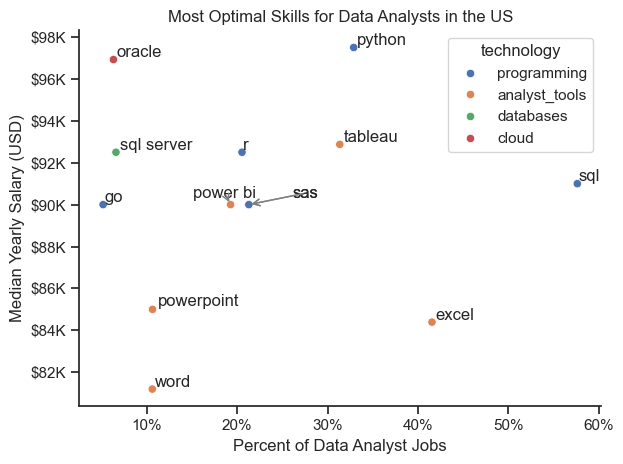

In [69]:
from adjustText import adjust_text

#df_plot.plot(kind='scatter', x='skill_percent', y='median_salary')
sns.scatterplot(
    data=df_plot,
    x='skill_percent', 
    y='median_salary', 
    hue='technology'
    )

# Set axis labels, title and legend
plt.title('Most Optimal Skills for Data Analysts in the US')
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary (USD)')


# Prepare texts for AdjustText
texts = []
for i in range(len(df_plot)):
    # Use the 'skill' column instead of index for text annotation
    skill_name = df_plot.loc[i, 'skills']
    x = df_plot.loc[i, 'skill_percent']
    y = df_plot.loc[i, 'median_salary']
    texts.append(plt.annotate(skill_name, (x, y)))

# Adjust text to avoid overlap
adjust_text(
    texts,
    autoalign='xy',  # Allow text to align automatically
    only_move={'points': 'y', 'texts': 'y'},  # Move only in the y-direction
    arrowprops=dict(arrowstyle='->', color='gray', lw=1),  # Optional arrows
    force_text=3.5,  # Increase force for spreading texts
    force_points=2.3  # Prevent text from colliding with points
)

# Layout adjustments
sns.despine()
sns.set_theme(style='ticks')
plt.tight_layout()

# Format y-axis as currency and x-axis as percentage
ax=plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{int(x):,}%'))

plt.show()